# Create a regression model for predicting housing prices using tree and ensemble models

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn import (
    model_selection,
    metrics,
    tree,
    ensemble
)
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## Importing data set

In [2]:
! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv --quiet

In [3]:
df = pd.read_csv('housing.csv')
df.sample(n=8)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
7016,-118.08,33.97,36.0,1678.0,323.0,1380.0,352.0,3.5481,163300.0,<1H OCEAN
10805,-117.94,33.62,25.0,1188.0,264.0,569.0,249.0,3.6607,500001.0,<1H OCEAN
6665,-118.09,34.17,36.0,2875.0,552.0,1131.0,458.0,4.3083,269300.0,INLAND
14376,-117.25,32.72,33.0,1677.0,228.0,629.0,239.0,6.5970,496400.0,NEAR OCEAN
7143,-118.13,34.02,40.0,2988.0,690.0,2144.0,667.0,2.3359,189300.0,<1H OCEAN
4267,-118.30,34.10,25.0,3926.0,1715.0,4865.0,1612.0,1.6112,262500.0,<1H OCEAN
16615,-120.92,35.40,23.0,2059.0,354.0,636.0,278.0,3.6908,278800.0,NEAR OCEAN
17431,-120.45,34.65,27.0,2215.0,578.0,1544.0,527.0,1.9257,135300.0,NEAR OCEAN


# Preparing the Data for Training

## Separate features and target

In [4]:
data, target = df.drop(columns=['median_house_value']), np.log1p(df['median_house_value'])

In [5]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [6]:
data['total_bedrooms'].fillna(0, inplace=True)

In [7]:
target.isna().sum()

0

## Training, Validation and Test Sets

In [8]:
X_full_train, X_test, y_full_train, y_test = model_selection.train_test_split(
    data,
    target,
    test_size=.2,
    random_state=1
)

X_train, X_dev, y_train, y_dev = model_selection.train_test_split(
    X_full_train,
    y_full_train,
    test_size=.25,
    random_state=1
)

X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape

((12384, 9), (12384,), (4128, 9), (4128,), (4128, 9), (4128,))

## Separate numerical and categorical variables

In [9]:
numerical = data.columns[:-1].to_list()
categorical = [data.columns[-1]]

print(numerical)
print()
print(categorical)

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

['ocean_proximity']


## One Hot Encoding

In [10]:
dict_train = X_train.to_dict(orient='records')
dict_dev = X_dev.to_dict(orient='records')
dict_test = X_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_dev = dv.transform(dict_dev)
X_test = dv.transform(dict_test)



## **Question 1**
train a decision tree regressor to predict the median_house_value variable.

`max_depth` = 1

Which feature is used for splitting the data?

In [11]:
dt_model = tree.DecisionTreeRegressor(max_depth=1)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

[Text(0.5, 0.75, 'ocean_proximity=INLAND <= 0.5\nsquared_error = 0.322\nsamples = 12384\nvalue = 12.088'),
 Text(0.25, 0.25, 'squared_error = 0.214\nsamples = 8483\nvalue = 12.307'),
 Text(0.75, 0.25, 'squared_error = 0.227\nsamples = 3901\nvalue = 11.613')]

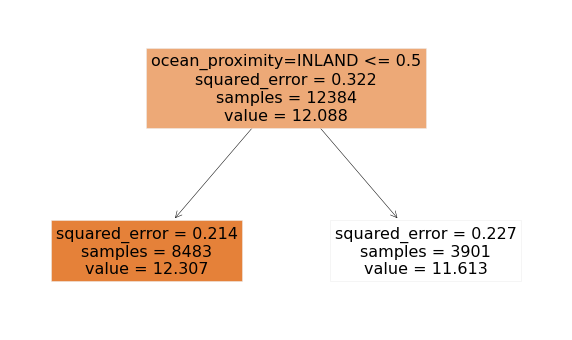

In [12]:
tree.plot_tree(
    dt_model,
    feature_names=dv.get_feature_names(), 
    max_depth=1, 
    filled=True
)

In [13]:
tree_text = tree.export_text(
    dt_model,
    feature_names=dv.get_feature_names(), 
    max_depth=1, 
)

print(tree_text[:5000])

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



## **Question 2**

Train a random forest model with these parameters:
- n_estimators=10
- random_state=1
- n_jobs=-1

In [14]:
rf_model = ensemble.RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

What's the RMSE of this model on validation?

In [15]:
y_pred = rf_model.predict(X_dev)
print(f"RMSE on validation: {metrics.mean_squared_error(y_dev, y_pred, squared=False):.2f}")

RMSE on validation: 0.25


## **Question 3**

**`n_estimators`**

estimator: 10 --> error: 0.246
estimator: 20 --> error: 0.239
estimator: 30 --> error: 0.235
estimator: 40 --> error: 0.234
estimator: 50 --> error: 0.233
estimator: 60 --> error: 0.233
estimator: 70 --> error: 0.232
estimator: 80 --> error: 0.232
estimator: 90 --> error: 0.232
estimator: 100 --> error: 0.232
estimator: 110 --> error: 0.231
estimator: 120 --> error: 0.232
estimator: 130 --> error: 0.232
estimator: 140 --> error: 0.232
estimator: 150 --> error: 0.232
estimator: 160 --> error: 0.232
estimator: 170 --> error: 0.231
estimator: 180 --> error: 0.232
estimator: 190 --> error: 0.232


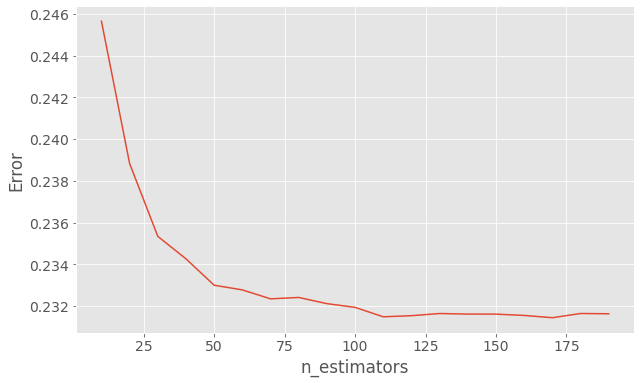

In [16]:
estimator_range = list(range(10, 200, 10))
errors = []
for i in estimator_range:
  rf_model = ensemble.RandomForestRegressor(
    n_estimators=i,
    random_state=1,
    n_jobs=-1
  )
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_dev)
  err = metrics.mean_squared_error(y_dev, y_pred, squared=False)
  errors.append(err)
  print(f"estimator: {i} --> error: {err:.3f}")

plt.figure()
plt.plot(estimator_range, errors)
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.show();

## **Question 4**

**`max_depth`**

In [17]:
depth_range = [10, 15, 20, 25]
errors = []

for depth in depth_range:
  print(f"{depth}:")
  for i in estimator_range:
    rf_model = ensemble.RandomForestRegressor(
        max_depth=depth,
        n_estimators=i,
        random_state=1,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_dev)
    err = metrics.mean_squared_error(y_dev, y_pred, squared=False)
    errors.append(err)
    print(f"estimator: {i} --> error: {err:.3f}")
  print("*-*-*" * 20)

10:
estimator: 10 --> error: 0.255
estimator: 20 --> error: 0.253
estimator: 30 --> error: 0.251
estimator: 40 --> error: 0.251
estimator: 50 --> error: 0.250
estimator: 60 --> error: 0.250
estimator: 70 --> error: 0.250
estimator: 80 --> error: 0.250
estimator: 90 --> error: 0.249
estimator: 100 --> error: 0.249
estimator: 110 --> error: 0.249
estimator: 120 --> error: 0.249
estimator: 130 --> error: 0.249
estimator: 140 --> error: 0.249
estimator: 150 --> error: 0.249
estimator: 160 --> error: 0.249
estimator: 170 --> error: 0.249
estimator: 180 --> error: 0.249
estimator: 190 --> error: 0.249
*-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-*
15:
estimator: 10 --> error: 0.245
estimator: 20 --> error: 0.239
estimator: 30 --> error: 0.237
estimator: 40 --> error: 0.236
estimator: 50 --> error: 0.235
estimator: 60 --> error: 0.235
estimator: 70 --> error: 0.234
estimator: 80 --> error: 0.234
estimator: 90 --> error: 0.234
estimator: 10

Best max_depth=25 with n_estimators=110

## **Question 5**

In [18]:
rf_model = ensemble.RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

importance_df = pd.DataFrame({
    'feature': dv.get_feature_names(),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

importance_df

,feature,importance
4,median_income,0.363326
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101256
3,longitude,0.096470
1,housing_median_age,0.033145
10,population,0.030777
12,total_rooms,0.020541
11,total_bedrooms,0.019172
0,households,0.016387
9,ocean_proximity=NEAR OCEAN,0.004699


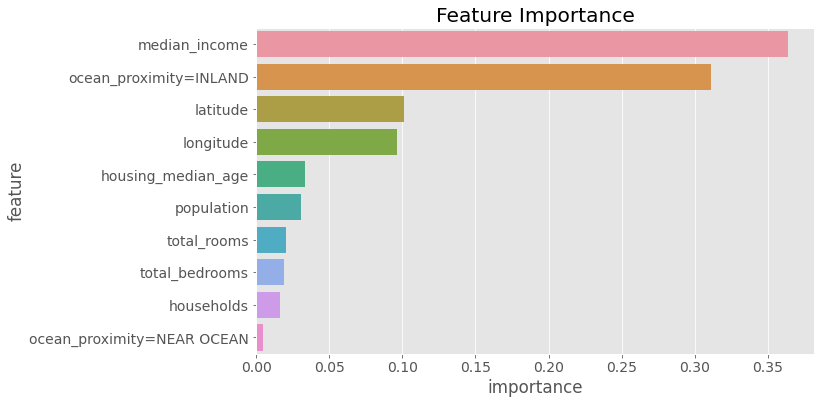

In [19]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## **Question6**

#### Eta=0.3

In [20]:
import xgboost as xgb 


dv.feature_names_ = ['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=less1H OCEAN',
 'ocean_proximity=INLAND',
 'ocean_proximity=ISLAND',
 'ocean_proximity=NEAR BAY',
 'ocean_proximity=NEAR OCEAN',
 'population',
 'total_bedrooms',
 'total_rooms'
 ]

dtrain = xgb.DMatrix(
    X_train, 
    label=y_train, 
    feature_names=dv.feature_names_,
)


dval = xgb.DMatrix(
    X_dev,
    label=y_dev,
    feature_names=dv.feature_names_,
)


xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100
)

In [21]:
y_pred = model.predict(dval)
metrics.mean_squared_error(y_dev, y_pred, squared=False)

0.22609578268142666

#### Eta=0.1

In [22]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100
)

y_pred = model.predict(dval)
metrics.mean_squared_error(y_dev, y_pred, squared=False)

0.2305416080901341

#### Eta=0.01

In [23]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100
)

y_pred = model.predict(dval)
metrics.mean_squared_error(y_dev, y_pred, squared=False)

4.264960724590359

Eta=0.3 is the best param